This is a replication of the model from the paper "Multi-Stage Pathological Image Classification using Semantic Segmentation". 

Structure of the model:
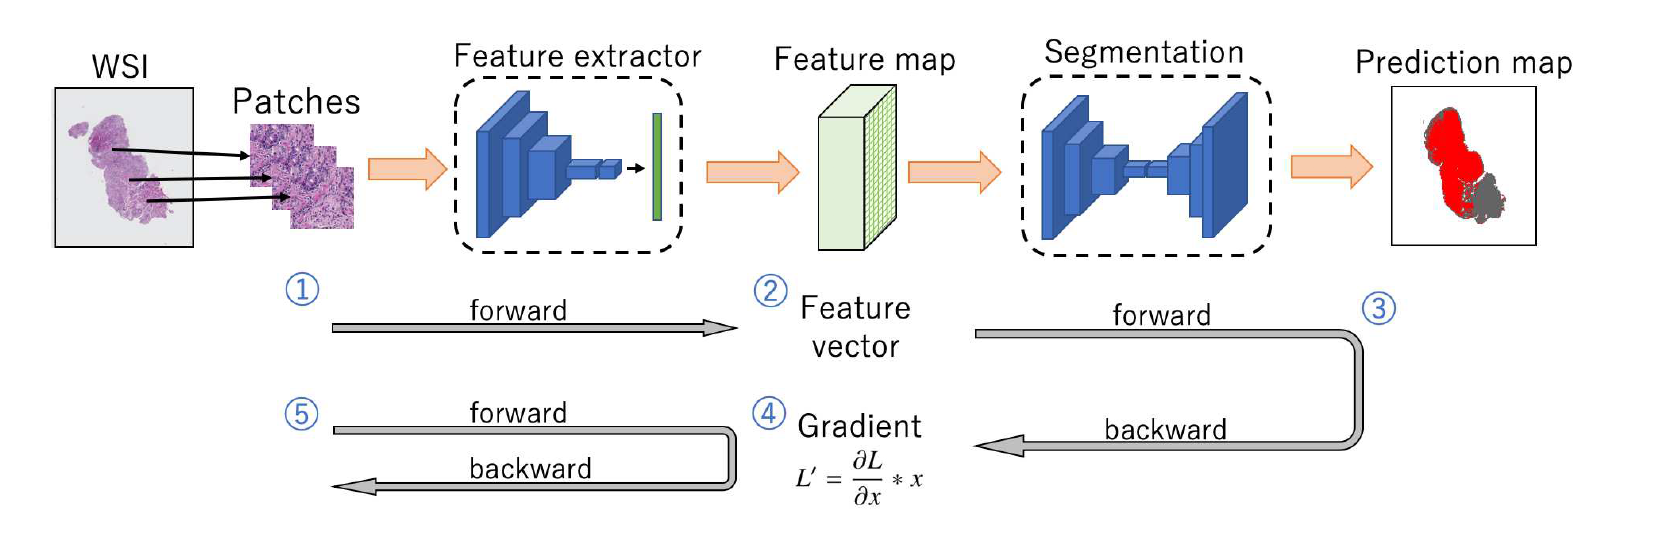

#Load data

Execute this code if using google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from tensorflow import keras
import os
# path = 'path to training set data'
path = '/content/drive/MyDrive/Colab Notebooks/WEEK9/training/day'
filename = os.listdir(path)


In [ ]:
# Load preprocessed data (need to double check code)
import h5py
cancer_image = []
cancer_label = []
for f in filename:
  image = h5py.File(path+'/'+f, 'r')
  data = image.get(f).value # data is now an ndarray. double check here. What is the dictionary key called?
  label = f.split('.')
  if label[0] == 'normal':
    cancer = 0
  elif label[0] == 'tumor':
    cancer = 1
  cancer_image.append(data)
  cancer_label.append(cancer)

# Feature Extractor


*   GoogLeNet pretrained by Imagenet 
*   add a fully connected layer before the final layer of GoogLeNet. The size of the feature vector is 16.
*   In Separate Learning, the learning rate of the
feature extractor model is 1e-4, and the model is trained 30
epochs with a batch size of 128.
*   The learning rate of the
segmentation model is 1e-4, and the model is trained 50
epochs with a batch size of 32. 
* In End-to-End Learning,
the learning rate is 1e-9 for the feature extractor model and
1e-7 for the segmentation model. The model is trained 10
epochs.



In [32]:
#Load the libraries
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, UpSampling2D
from keras.layers.merge import concatenate
from tensorflow.nn import local_response_normalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt


The below GoogleNet architecture is described in the paper "Going Deeper with Convolutions" by Szegedy et al (2015). 

In [19]:
# Dimension Reduction Inception
def inception_dimred(layer_in,k1):
  # 1st
  conv1 = Conv2D(k1, (1,1),  activation='relu')(layer_in)
  # 2nd
  conv2_1 = Conv2D(k1, (1,1), activation='relu')(layer_in)
  conv2 = Conv2D(k1, (3,3),padding = 'same',  activation='relu')(conv2_1)
  # 3rd
  conv3_1 = Conv2D(k1, (1,1), padding = 'same',activation='relu')(layer_in)
  conv3 = Conv2D(k1, (5,5),padding = 'same', activation='relu')(conv3_1)
  # 4th
  pool = MaxPooling2D((1,1), padding='same')(layer_in)
  conv4 = Conv2D(k1, (1,1), activation = 'relu')(pool)

  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv2, conv3, conv4], axis=-1)
  return layer_out

 





In [30]:
# GoogleNet
def googlenet(layer_in = Input(shape=(256, 256, 3))):
  conv1 = Conv2D(64, (7,7), strides= (2,2), padding='same', activation='relu')(layer_in)
  pool1 = MaxPooling2D((3,3), strides= (2,2), padding='same')(conv1)
  norm1 = local_response_normalization(pool1)

  conv2 = Conv2D(192, (1,1), padding='valid', activation='relu')(norm1)

  conv3 = Conv2D(192, (3,3), padding='same', activation='relu')(conv2)
  norm3 = local_response_normalization(conv3)
  pool3 = MaxPooling2D((3,3), strides= (2,2), padding='same')(norm3)
  incep3a = inception_dimred(pool3, 256)
  incep3b = inception_dimred(incep3a, 480)

  pool4 = MaxPooling2D((3,3), strides= (2,2), padding='same')(incep3b)
  incep4a = inception_dimred(pool4,512)


  # first softmax with incep4a
  avg_a = AveragePooling2D(pool_size=(5, 5), strides=(3,3), padding='valid')(incep4a)
  conv_a = Conv2D(512, (1,1), padding='valid', activation='relu')(avg_a)
  flat_a = Flatten()(conv_a)
  dense_a = Dense(1024, activation='relu')(flat_a)
  softmax_0 = Dense(1000, activation='softmax')(dense_a)

  incep4b = inception_dimred(incep4a,512)
  incep4c = inception_dimred(incep4b,512)
  incep4d = inception_dimred(incep4c, 528)

  # second softmax with incep4d
  avg_b = AveragePooling2D(pool_size=(5, 5), strides=(3,3), padding='valid')(incep4d)
  conv_b = Conv2D(528, (1,1), padding='valid', activation='relu')(avg_b)
  flat_b = Flatten()(conv_b)
  dense_b = Dense(1024, activation='relu')(flat_b)
  softmax_1 = Dense(1000, activation='softmax')(dense_b)

  incep4e = inception_dimred(incep4d, 832)

  pool5 = MaxPooling2D((3,3), strides= (2,2), padding='same')(incep3b)
  incep5a = inception_dimred(incep4e, 832)
  incep5b = inception_dimred(incep5a, 1024)

  # third softmax with incep5b
  avg_c = AveragePooling2D(pool_size=(7, 7), padding='valid')(incep5b)
  drop_c = Dropout(0.4)(avg_c)
  flat_c = Flatten()(drop_c)
  dense_c = Dense(1024, activation='linear')(flat_c)
  softmax_2 = Dense(2, activation='softmax')(dense_c)

  result = softmax_2

  # create model
  model = Model(inputs=layer_in, outputs=result)
  return model

In [31]:
model_googlenet = googlenet()
model_googlenet.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# summarize model
model_googlenet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 128, 128, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_118[0][0]                 
__________________________________________________________________________________________________
tf.nn.local_response_normalizat (None, 64, 64, 64)   0           max_pooling2d_26[0][0]           
____________________________________________________________________________________________

In [ ]:
# Data Generator for Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_datagen = ImageDataGenerator(rotation_range=2, horizontal_flip=True, vertical_flip = True, zoom_range=0.1 )
image_datagen.fit(X_train)
BATCH_SIZE = 100
train_generator = image_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
validation_generator = image_datagen.flow(X_valid, Y_valid, batch_size=BATCH_SIZE)

In [ ]:
# Define Model Parameter
epochs = 50
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Train Model
history = model.fit_generator( 
    generator=train_generator, 
    steps_per_epoch=None, #Will run until batches exhausted 
    epochs = epochs, 
    validation_data=validation_generator,  
    validation_steps=None, #Will run until batches exhausted 
    callbacks=[model_checkpoint_callback], 
    workers=1, 
    use_multiprocessing=False,
    max_queue_size=10)


# Feature Map

In [ ]:
# Construct feature maps and reshape them into 256*256*3 for UNet
layer_outputs = [layer.output for layer in model_googlenet.layers]
feature_model = Model(inputs=model_googlenet.input, outputs=layer_outputs)
feature_map_total = []
for x in range(0,len(X_train)):
  feature_map = feature_model.predict(X_train[x].reshape(1,256,256,3)) 
  feature_map_total.append(feature_map)

# Segmentation



*   use U-Net as the segmentation model. 




In [ ]:
  def unet(layer_in = Input(shape=(256, 256, 3))):
    inputs = layer_in
    # conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dilation_rate=2 etc.
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(inputs) #dilation_rate=2 etc.
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(conv1) #dilation_rate=2 etc.
    # conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    # conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    # conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    # conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    # conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5) 

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8) 

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
 model_unet = unet()
 model_unet.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# summarize model
model_unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_355 (Conv2D)             (None, 256, 256, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_356 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_355[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_79 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_356[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Fit UNet on feature maps
model_unet.fit(x = feature_map_total, y = cancer_label, batch_size = 100, epochs = 50)

# Prediction Map

In [ ]:
# Print prediction map
layer_outputs = [layer.output for layer in model_unet.layers]
prediction_model = Model(inputs=model_unet.input, outputs=layer_outputs)
prediction = prediction_model.predict(X_train[10].reshape(1,512,512,3)) #Pick 10 to print out prediction
 
def display_prediction_map(prediction, col_size, row_size, act_index): 
    pred = prediction[act_index]
    prediction_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(pred[0, :, :, prediction_index])
            prediction_index += 1

display_prediction_map(prediction, 8, 8, 0) #For layer 0